<center><img src="./imgs/scicrop" width="150" height="100" align="center"/></center>

# **Processo seletivo para Estágio em Data Science - SciCrop 2020**

# Preparação dos dados

Este notebook contém a preparação dos dados fornecidos no problema proposto pela SciCrop em sua etapa  de avaliação técnica, e eles serão alimentados a um modelo de predição que será discutido no notebook [`modelo.ipynb`](modelo.ipynb). A discussão da análise sobre os dados é feita no notebook [`analise.ipynb`](analise.ipynb), onde extraiu-se algumas conclusões úteis e que serão usadas nesta etapa.

## **Índice** <a class="anchor" id="index"></a>
- [Processos de tratamento](#data-prep__process)
- [Condensando tudo em uma função](#data-prep__func)

## **Processos de tratamento**  <a class="anchor" id="data-prep__process"></a>

[Voltar para o índice](#index)

Como discutido no notebook [`analise.ipynb`](analise.ipynb), os dados apresentam alguns valores nulos no atributo *'Semanas_Utilizando'* em ambos os dados ([`Safra_2018-2019.csv`](Safra_2018-2019.csv) e [`Safra_2020.csv`](Safra_2020.csv)). Ainda, discutido no mesmo notebook, concluiu-se que alguns atributos possuem maior correlação com os danos causados do que outros, e que é possível utilizar dos atributos já fornecidos para criar outros dois novos, que são:
- A combinação dos atributos categóricos *'Tipo_de_Solo' e 'Tipo_de_Cultivo'* em um novo atributo categórico denominado *'Tipo_de_Solo_Cultivo'*
- A combinação dos atributos numéricos *'Doses_por_Semana' e 'Semanas_Utilizando'* em um novo atributo numérico denominado *'Dose_Total'*

Logo, o processo de processamento dos dados consistirá nas seguintes etapas:

- Utilizar um *imputer* para preencher os valores nulos no atributo *'Semanas_Utilizando'*
- Gerar os atributos *'Tipo_de_Solo_Cultivo'* e *'Dose_Total'*
- Dropar os atributos com menores correlações (*'Doses_Semana', 'Tipo_de_Cultivo', 'Tipo_de_Solo' e 'Temporada'*), bem como o identificador ('Identificador_Agricultor')
- Separar os atributos numéricos dos categóricos
- Aplicar um *Scaler* sobre os dados numéricos
- Aplicar um *Encoder* sobre os dados categóricos
- Transformar as modificações feitas em apenas um *Dataframe*

In [1]:
import numpy as np
import pandas as pd

from sklearn.impute import SimpleImputer

In [2]:
import autoreload
%load_ext autoreload
%autoreload 2
from analysis import *

In [3]:
train = pd.read_csv('Safra_2018-2019.csv', index_col = 0)
train.head()

,Identificador_Agricultor,Estimativa_de_Insetos,Tipo_de_Cultivo,Tipo_de_Solo,Categoria_Pesticida,Doses_Semana,Semanas_Utilizando,Semanas_Sem_Uso,Temporada,dano_na_plantacao
0,SCROP00001,188,1,0,1,0,0.0,0,1,0
1,SCROP00002,209,1,0,1,0,0.0,0,2,1
2,SCROP00003,257,1,0,1,0,0.0,0,2,1
3,SCROP00004,257,1,1,1,0,0.0,0,2,1
4,SCROP00005,342,1,0,1,0,0.0,0,2,1


Number of instances : 80000
Number of variables : 10
--------------------
Attributes, data type and ratio of unique instances por total non-null:
	 - Identificador_Agricultor, object, 80000/80000
	 - Estimativa_de_Insetos, int64, 71/80000
	 - Tipo_de_Cultivo, int64, 2/80000
	 - Tipo_de_Solo, int64, 2/80000
	 - Categoria_Pesticida, int64, 3/80000
	 - Doses_Semana, int64, 20/80000
	 - Semanas_Utilizando, float64, 64/71945
	 - Semanas_Sem_Uso, int64, 51/80000
	 - Temporada, int64, 3/80000
	 - dano_na_plantacao, int64, 3/80000
--------------------
Attributes that have missing values: 
Semanas_Utilizando    8055
dtype: int64
--------------------
Pictorial representation of missing values:


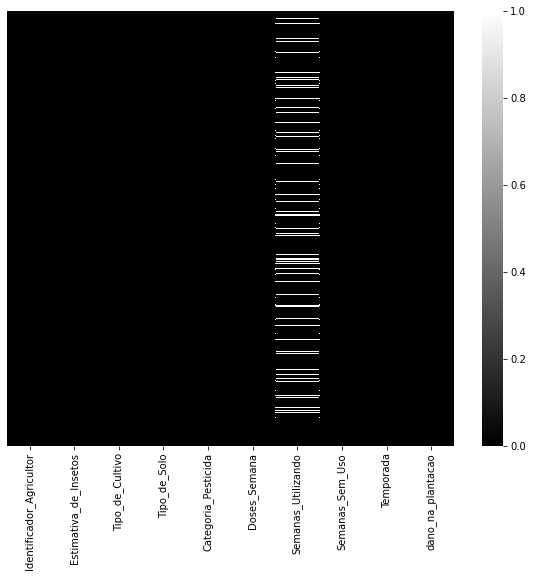

In [4]:
data_investigation(train)

### Imputando os dados

In [5]:
def impute_vals(df, target, strategy = 'median'):
    imp_median = SimpleImputer(missing_values=np.nan, strategy=strategy)
    vals = imp_median.fit_transform(df[target].values.reshape(-1, 1))
    
    df[target] = vals
    return df

In [6]:
train = impute_vals(train, 'Semanas_Utilizando')

Number of instances : 80000
Number of variables : 10
--------------------
Attributes, data type and ratio of unique instances por total non-null:
	 - Identificador_Agricultor, object, 80000/80000
	 - Estimativa_de_Insetos, int64, 71/80000
	 - Tipo_de_Cultivo, int64, 2/80000
	 - Tipo_de_Solo, int64, 2/80000
	 - Categoria_Pesticida, int64, 3/80000
	 - Doses_Semana, int64, 20/80000
	 - Semanas_Utilizando, float64, 64/80000
	 - Semanas_Sem_Uso, int64, 51/80000
	 - Temporada, int64, 3/80000
	 - dano_na_plantacao, int64, 3/80000
--------------------
Attributes that have missing values: 
Series([], dtype: int64)
--------------------
Pictorial representation of missing values:


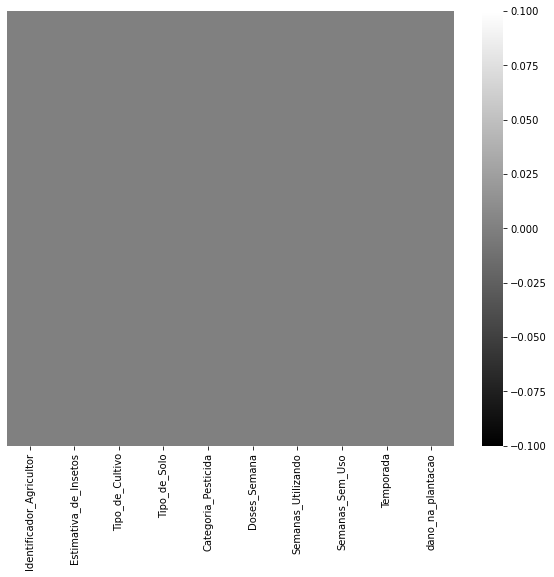

In [7]:
data_investigation(train)

### Gerando os novos atributos (*'Tipo_de_Solo_cultivo' e 'Dose_Total'*)

In [8]:
def create_attr(df):
    ## 'Tipo_de_Solo_Cultivo'
    df.loc[((df.Tipo_de_Solo == 0) & (df.Tipo_de_Cultivo == 0)), 'Tipo_de_Solo_Cultivo'] = 0
    df.loc[((df.Tipo_de_Solo == 0) & (df.Tipo_de_Cultivo == 1)), 'Tipo_de_Solo_Cultivo'] = 1
    df.loc[((df.Tipo_de_Solo == 1) & (df.Tipo_de_Cultivo == 0)), 'Tipo_de_Solo_Cultivo'] = 2
    df.loc[((df.Tipo_de_Solo == 1) & (df.Tipo_de_Cultivo == 1)), 'Tipo_de_Solo_Cultivo'] = 3
    
    ## 'Dose_Total'
    df['Dose_Total'] = df['Doses_Semana']*df['Semanas_Utilizando']
    return df

In [9]:
train = create_attr(train)

In [10]:
train.head()

,Identificador_Agricultor,Estimativa_de_Insetos,Tipo_de_Cultivo,Tipo_de_Solo,Categoria_Pesticida,Doses_Semana,Semanas_Utilizando,Semanas_Sem_Uso,Temporada,dano_na_plantacao,Tipo_de_Solo_Cultivo,Dose_Total
0,SCROP00001,188,1,0,1,0,0.0,0,1,0,1.0,0.0
1,SCROP00002,209,1,0,1,0,0.0,0,2,1,1.0,0.0
2,SCROP00003,257,1,0,1,0,0.0,0,2,1,1.0,0.0
3,SCROP00004,257,1,1,1,0,0.0,0,2,1,3.0,0.0
4,SCROP00005,342,1,0,1,0,0.0,0,2,1,1.0,0.0


### Dropando os atributos *'Doses_Semana', 'Tipo_de_Cultivo', 'Tipo_de_Solo' e 'Temporada'*

In [11]:
def drop_feats(df, targets):
    return df.drop(targets, axis = 1)

In [12]:
feats_to_drop = ['Doses_Semana', 'Tipo_de_Cultivo', 'Tipo_de_Solo', 'Temporada']
train = drop_feats(train, feats_to_drop)

In [13]:
train.head()

,Identificador_Agricultor,Estimativa_de_Insetos,Categoria_Pesticida,Semanas_Utilizando,Semanas_Sem_Uso,dano_na_plantacao,Tipo_de_Solo_Cultivo,Dose_Total
0,SCROP00001,188,1,0.0,0,0,1.0,0.0
1,SCROP00002,209,1,0.0,0,1,1.0,0.0
2,SCROP00003,257,1,0.0,0,1,1.0,0.0
3,SCROP00004,257,1,0.0,0,1,3.0,0.0
4,SCROP00005,342,1,0.0,0,1,1.0,0.0


### Separação de atributos numéricos e categóricos

In [14]:
num_feats = ['Estimativa_de_Insetos', 'Semanas_Utilizando', 'Semanas_Sem_Uso', 'Dose_Total']
cat_feats = ['Categoria_Pesticida', 'Tipo_de_Solo_Cultivo']
label_feat = ['dano_na_plantacao']
id_feat = ['Identificador_Agricultor']

train_num = train[num_feats]
train_cat = train[cat_feats]
train_label = train[label_feat]
train_id = train[id_feat]

In [15]:
train_num.head()

,Estimativa_de_Insetos,Semanas_Utilizando,Semanas_Sem_Uso,Dose_Total
0,188,0.0,0,0.0
1,209,0.0,0,0.0
2,257,0.0,0,0.0
3,257,0.0,0,0.0
4,342,0.0,0,0.0


In [16]:
train_cat.head()

,Categoria_Pesticida,Tipo_de_Solo_Cultivo
0,1,1.0
1,1,1.0
2,1,1.0
3,1,3.0
4,1,1.0


In [17]:
train_label.head()

,dano_na_plantacao
0,0
1,1
2,1
3,1
4,1


### Aplicando um *Scaler* sobre os atributos numéricos

In [18]:
from sklearn.preprocessing import StandardScaler

In [19]:
def scaler(df):
    std_scaler = StandardScaler()
    df_scaled = std_scaler.fit_transform(df)
    return df_scaled

In [20]:
train_num = scaler(train_num)
train_num

array([[-1.42626405, -2.4267593 , -0.96402015, -1.32672622],
       [-1.40155198, -2.4267593 , -0.96402015, -1.32672622],
       [-1.34506725, -2.4267593 , -0.96402015, -1.32672622],
       ...,
       [-1.34624401, -1.23873444,  0.04552149, -1.08254947],
       [-1.34624401, -1.0690166 , -0.15638683, -1.04766707],
       [-1.34624401, -1.49331119,  0.04552149, -0.94301989]])

### Aplicando um *Encoder* sobre os atributos categóricos

In [21]:
from sklearn.preprocessing import OneHotEncoder

In [22]:
def ohe(df):
    ohe_enc = OneHotEncoder()
    df_encoded = ohe_enc.fit_transform(df).toarray()
    return df_encoded

In [23]:
train_cat = ohe(train_cat)
train_cat

array([[1., 0., 0., ..., 1., 0., 0.],
       [1., 0., 0., ..., 1., 0., 0.],
       [1., 0., 0., ..., 1., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 1., 0.],
       [0., 1., 0., ..., 0., 1., 0.],
       [0., 1., 0., ..., 0., 1., 0.]])

### Condensando em um DataFrame

In [24]:
train_out = np.concatenate([train_num, train_cat], axis = 1)
train_out = pd.DataFrame(train_out, columns = None)

In [25]:
train_out

,0,1,2,3,4,5,6,7,8,9,10
0,-1.426264,-2.426759,-0.964020,-1.326726,1.0,0.0,0.0,0.0,1.0,0.0,0.0
1,-1.401552,-2.426759,-0.964020,-1.326726,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2,-1.345067,-2.426759,-0.964020,-1.326726,1.0,0.0,0.0,0.0,1.0,0.0,0.0
3,-1.345067,-2.426759,-0.964020,-1.326726,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4,-1.245042,-2.426759,-0.964020,-1.326726,1.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
79995,-1.401552,-1.408452,-0.358295,-0.908137,0.0,1.0,0.0,0.0,0.0,1.0,0.0
79996,-1.374486,-1.408452,-0.055433,-0.908137,0.0,1.0,0.0,0.0,0.0,1.0,0.0
79997,-1.346244,-1.238734,0.045521,-1.082549,0.0,1.0,0.0,0.0,0.0,1.0,0.0
79998,-1.346244,-1.069017,-0.156387,-1.047667,0.0,1.0,0.0,0.0,0.0,1.0,0.0


In [26]:
cat_feats = ['Categoria_Pesticida_1',
             'Categoria_Pesticida_2',
             'Categoria_Pesticida_3',
             'Tipo_de_Solo_Cultivo_0',
             'Tipo_de_Solo_Cultivo_1',
             'Tipo_de_Solo_Cultivo_2',
             'Tipo_de_Solo_Cultivo_3',
            ]

cols = num_feats+cat_feats+label_feat

In [27]:
train_out = pd.concat([train_out, train_label], axis = 1)

In [28]:
train_out.columns = cols
train_out.index = train_id.iloc[:, 0]

In [29]:
train_out.head()

,Estimativa_de_Insetos,Semanas_Utilizando,Semanas_Sem_Uso,Dose_Total,Categoria_Pesticida_1,Categoria_Pesticida_2,Categoria_Pesticida_3,Tipo_de_Solo_Cultivo_0,Tipo_de_Solo_Cultivo_1,Tipo_de_Solo_Cultivo_2,Tipo_de_Solo_Cultivo_3,dano_na_plantacao
Identificador_Agricultor,,,,,,,,,,,,
SCROP00001,-1.426264,-2.426759,-0.96402,-1.326726,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0
SCROP00002,-1.401552,-2.426759,-0.96402,-1.326726,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1
SCROP00003,-1.345067,-2.426759,-0.96402,-1.326726,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1
SCROP00004,-1.345067,-2.426759,-0.96402,-1.326726,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1
SCROP00005,-1.245042,-2.426759,-0.96402,-1.326726,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1


## **Condensando tudo em uma função** <a class="anchor" id="data-prep__func"></a>

[Voltar para o índice](#index)

In [30]:
def full_transform(df_in, train_set=True):
    ## Imputing
    df = impute_vals(df_in, 'Semanas_Utilizando')
    
    ## Criando atributos
    df = create_attr(df)
    
    ## Dropando atributos
    feats_to_drop = ['Doses_Semana', 'Tipo_de_Cultivo', 'Tipo_de_Solo', 'Temporada']
    df = drop_feats(df, feats_to_drop)
    
    ## Separando atributos numéricos e categóricos
    num_feats = ['Estimativa_de_Insetos', 'Semanas_Utilizando', 'Semanas_Sem_Uso', 'Dose_Total']
    cat_feats = ['Categoria_Pesticida', 'Tipo_de_Solo_Cultivo']
    id_feat = ['Identificador_Agricultor']
    if train_set:
        label_feat = ['dano_na_plantacao']
        df_label = df[label_feat]

    df_num = df[num_feats]
    df_cat = df[cat_feats]
    df_id = df[id_feat]
    
    ## Aplicando Scaling e Encoding nos atributos numéricos e categóricos, respectivamente
    df_num = scaler(df_num)
    df_cat = ohe(df_cat)
    
    ## Condensando em uma DataFrame
    df_out = np.concatenate([df_num, df_cat], axis = 1)
    df_out = pd.DataFrame(df_out, columns = None)
    
    cat_feats = ['Categoria_Pesticida_1',
             'Categoria_Pesticida_2',
             'Categoria_Pesticida_3',
             'Tipo_de_Solo_Cultivo_0',
             'Tipo_de_Solo_Cultivo_1',
             'Tipo_de_Solo_Cultivo_2',
             'Tipo_de_Solo_Cultivo_3',
            ]

    if train_set:
        cols = num_feats+cat_feats+label_feat
        df_out = pd.concat([df_out, df_label], axis = 1)
    else:
        cols = num_feats+cat_feats
    
    df_out.columns = cols
    df_out.index = df_id.iloc[:, 0]
    
    return df_out

In [31]:
train_in = pd.read_csv('Safra_2018-2019.csv', index_col = 0)
train_in.head()

,Identificador_Agricultor,Estimativa_de_Insetos,Tipo_de_Cultivo,Tipo_de_Solo,Categoria_Pesticida,Doses_Semana,Semanas_Utilizando,Semanas_Sem_Uso,Temporada,dano_na_plantacao
0,SCROP00001,188,1,0,1,0,0.0,0,1,0
1,SCROP00002,209,1,0,1,0,0.0,0,2,1
2,SCROP00003,257,1,0,1,0,0.0,0,2,1
3,SCROP00004,257,1,1,1,0,0.0,0,2,1
4,SCROP00005,342,1,0,1,0,0.0,0,2,1


In [32]:
train_out = full_transform(train_in)
train_out.head()

,Estimativa_de_Insetos,Semanas_Utilizando,Semanas_Sem_Uso,Dose_Total,Categoria_Pesticida_1,Categoria_Pesticida_2,Categoria_Pesticida_3,Tipo_de_Solo_Cultivo_0,Tipo_de_Solo_Cultivo_1,Tipo_de_Solo_Cultivo_2,Tipo_de_Solo_Cultivo_3,dano_na_plantacao
Identificador_Agricultor,,,,,,,,,,,,
SCROP00001,-1.426264,-2.426759,-0.96402,-1.326726,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0
SCROP00002,-1.401552,-2.426759,-0.96402,-1.326726,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1
SCROP00003,-1.345067,-2.426759,-0.96402,-1.326726,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1
SCROP00004,-1.345067,-2.426759,-0.96402,-1.326726,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1
SCROP00005,-1.245042,-2.426759,-0.96402,-1.326726,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1


In [33]:
pred_in = pd.read_csv('Safra_2020.csv', index_col = 0)
pred_in.head()

,Identificador_Agricultor,Estimativa_de_Insetos,Tipo_de_Cultivo,Tipo_de_Solo,Categoria_Pesticida,Doses_Semana,Semanas_Utilizando,Semanas_Sem_Uso,Temporada
80000,SCROP80001,256,0,1,2,35,11.0,9,1
80001,SCROP80002,283,0,1,2,5,5.0,6,1
80002,SCROP80003,283,0,1,2,15,15.0,5,2
80003,SCROP80004,283,0,1,2,15,NaN,7,2
80004,SCROP80005,283,0,1,2,15,19.0,2,1


In [34]:
pred_out = full_transform(pred_in, train_set=False)
pred_out.head()

,Estimativa_de_Insetos,Semanas_Utilizando,Semanas_Sem_Uso,Dose_Total,Categoria_Pesticida_1,Categoria_Pesticida_2,Categoria_Pesticida_3,Tipo_de_Solo_Cultivo_0,Tipo_de_Solo_Cultivo_1,Tipo_de_Solo_Cultivo_2,Tipo_de_Solo_Cultivo_3
Identificador_Agricultor,,,,,,,,,,,
SCROP80001,-1.346281,-1.498407,-0.097412,-0.643209,0.0,1.0,0.0,0.0,0.0,1.0,0.0
SCROP80002,-1.314224,-2.023497,-0.402029,-1.272683,0.0,1.0,0.0,0.0,0.0,1.0,0.0
SCROP80003,-1.314224,-1.148346,-0.503568,-0.922975,0.0,1.0,0.0,0.0,0.0,1.0,0.0
SCROP80004,-1.314224,-0.098165,-0.300490,-0.608238,0.0,1.0,0.0,0.0,0.0,1.0,0.0
SCROP80005,-1.314224,-0.798286,-0.808186,-0.818063,0.0,1.0,0.0,0.0,0.0,1.0,0.0


Demonstra-se que todos os dados estão devidamente ajustados, e prontos para serem alimentados aos modelos de predição. As funções escritas neste notebook estão presente também no arquivo [`datahandle.py`](datahandle.py). Elas serão usadas no treinamento do modelo, discutido em [`modelo.ipynb`](modelo.ipynb).